In [1]:
# run CW ODMR.
# control the frequency changes "manually" with the code here instead of using external trigger

In [1]:
%matplotlib inline

In [2]:
import nidaqmx
import numpy as np
import qt3rfsynthcontrol
import ctypes
import nidaqmx._lib  # Due to NIDAQmx C-API bug needed to bypass property getter (according to qudi)
import nidaqmx.stream_readers
import time
import matplotlib.pyplot as plt

In [5]:
#Configure the NI DAQ

def configure_tasks(post_fix_task_name = None, 
                    device_name = 'Dev1',
                    clock_counter = 'ctr1',
                    edge_input_channel = 'PFI0',
                    edge_input_counter = 'ctr2',
                    clock_rate = 1000, 
                    N_data_samples_to_acquire = 500):
   
    clock_task_name = f'sample_clock{post_fix_task_name}' 
    clock_task = nidaqmx.Task(clock_task_name)
       
    #this adds the clock singal to the output channel 
    clock_task.co_channels.add_co_pulse_chan_freq(
            '/{0}/{1}'.format(device_name, clock_counter),
            freq=clock_rate,
            idle_state=nidaqmx.constants.Level.LOW)

    # clock_task.timing.cfg_implicit_timing(
    #     sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
    #     samps_per_chan=n_steps+2) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

    clock_task.timing.cfg_implicit_timing(
        sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
        samps_per_chan=1000) #qudi configures with n_steps + 1, should recheck why. suspicious extra "1" floating around (n_steps = 101)

    
    edge_detector_task_name = f'edge_input{post_fix_task_name}'

    edge_detector_task = nidaqmx.Task(edge_detector_task_name)

    ctr_name = '/{0}/{1}'.format(device_name, edge_input_counter)
    edge_detector_task.ci_channels.add_ci_period_chan(
                        ctr_name,
                        min_val=0,
                        max_val=100000000,
                        units=nidaqmx.constants.TimeUnits.TICKS,
                        edge=nidaqmx.constants.Edge.RISING)

    # from qudi -- apparently this overcomes some kind of bug in the C-library, according to comments in qudi code
    chnl_name = '/{0}/{1}'.format(device_name, edge_input_channel)
    clock_channel = '/{0}InternalOutput'.format(clock_task.channel_names[0])

    try:
        nidaqmx._lib.lib_importer.windll.DAQmxSetCIPeriodTerm(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(clock_channel.encode('ascii')))
        nidaqmx._lib.lib_importer.windll.DAQmxSetCICtrTimebaseSrc(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(chnl_name.encode('ascii')))
    except:
        nidaqmx._lib.lib_importer.cdll.DAQmxSetCIPeriodTerm(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(clock_channel.encode('ascii')))
        nidaqmx._lib.lib_importer.cdll.DAQmxSetCICtrTimebaseSrc(
            edge_detector_task._handle,
            ctypes.c_char_p(ctr_name.encode('ascii')),
            ctypes.c_char_p(chnl_name.encode('ascii')))

    edge_detector_task.timing.cfg_implicit_timing(
        sample_mode=nidaqmx.constants.AcquisitionType.FINITE,
        samps_per_chan=N_data_samples_to_acquire)

    edge_detector_reader = nidaqmx.stream_readers.CounterReader(edge_detector_task.in_stream)
    
    return clock_task, edge_detector_task, edge_detector_reader



In [6]:
def run_once(detector_task, detector_reader, clock_rate,  N_samples,  read_write_timeout=10):
    detector_task.start()
    data_buffer = np.zeros(N_samples)
    time.sleep(1.1*N_samples / clock_rate) # need to wait for data to acquire
    read_samples = detector_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=read_write_timeout)
    detector_task.stop()
    try:
        assert read_samples == N_samples
    except Exception as e:
        print(e)
        print(f'{read_samples} != {N_samples}')
        raise e
        
    return data_buffer

In [7]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [8]:
rfsynth.hw_info()

[('model_type', 'WFT SynthHD 1694'),
 ('serial_number', 1694),
 ('fw_version', 'Firmware Version 3.23'),
 ('hw_version', 'Hardware Version 2.06'),
 ('sub_version', 'HD')]

In [13]:
freq_low = 2820e6
freq_high = 3130e6
freq_step = 1e6

N = 50
clock_rate = 200
clock_task, edge_detector_task, edge_detector_reader = configure_tasks(post_fix_task_name = 'v3', 
                                                                       clock_rate = clock_rate, 
                                                                       N_data_samples_to_acquire = N)

clock_task.start()

In [14]:
data = {}
rfsynth.rf_on(0)
current_freq = freq_low
step = 0
while current_freq < freq_high:
    rfsynth.set_channel_fixed_output(0, -5.0, current_freq)
    data_at_one_freq = run_once(edge_detector_task, edge_detector_reader, clock_rate, N)
    data[current_freq] = data_at_one_freq.mean()*clock_rate
    if step % 10 == 0:
        print(f'{current_freq/1e9} GHz: {data_at_one_freq.mean()*clock_rate}')
    current_freq += freq_step
    step += 1

  

In [16]:
rfsynth.rf_off(0)
clock_task.stop()
clock_task.close()
edge_detector_task.close()

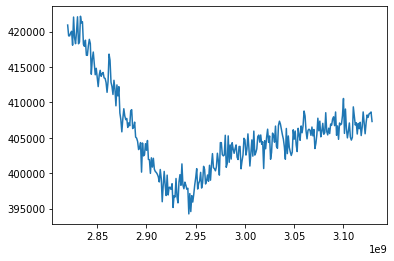

In [15]:
plt.plot(data.keys(), data.values())

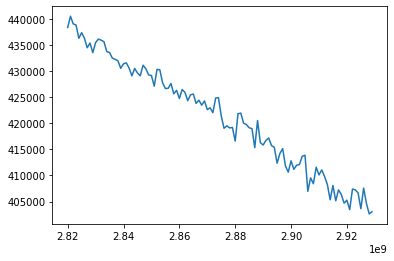

In [12]:
plt.plot(data.keys(), data.values())

In [17]:
rfsynth.close()